Number of rows with missing values: 0

Final validation:
Max Weekly Case Rate: 1978.832
Typical Chicago rates should be < 2000 in peak weeks

Correlation with 'Cases - Weekly':
Cases - Weekly                          1.000000
Case Rate - Weekly                      0.952873
Tests - Weekly                          0.629610
Test Rate - Weekly                      0.605444
Deaths - Weekly                         0.417392
Death Rate - Weekly                     0.378141
Population                              0.196177
Percent Tested Positive - Weekly        0.138738
Percent Tested Positive - Cumulative    0.081098
Tests - Cumulative                      0.041052
Deaths - Cumulative                     0.003071
Region                                 -0.015782
Test Rate - Cumulative                 -0.016863
Cases - Cumulative                     -0.054739
Death Rate - Cumulative                -0.132507
Case Rate - Cumulative                 -0.143272
Week Number                            

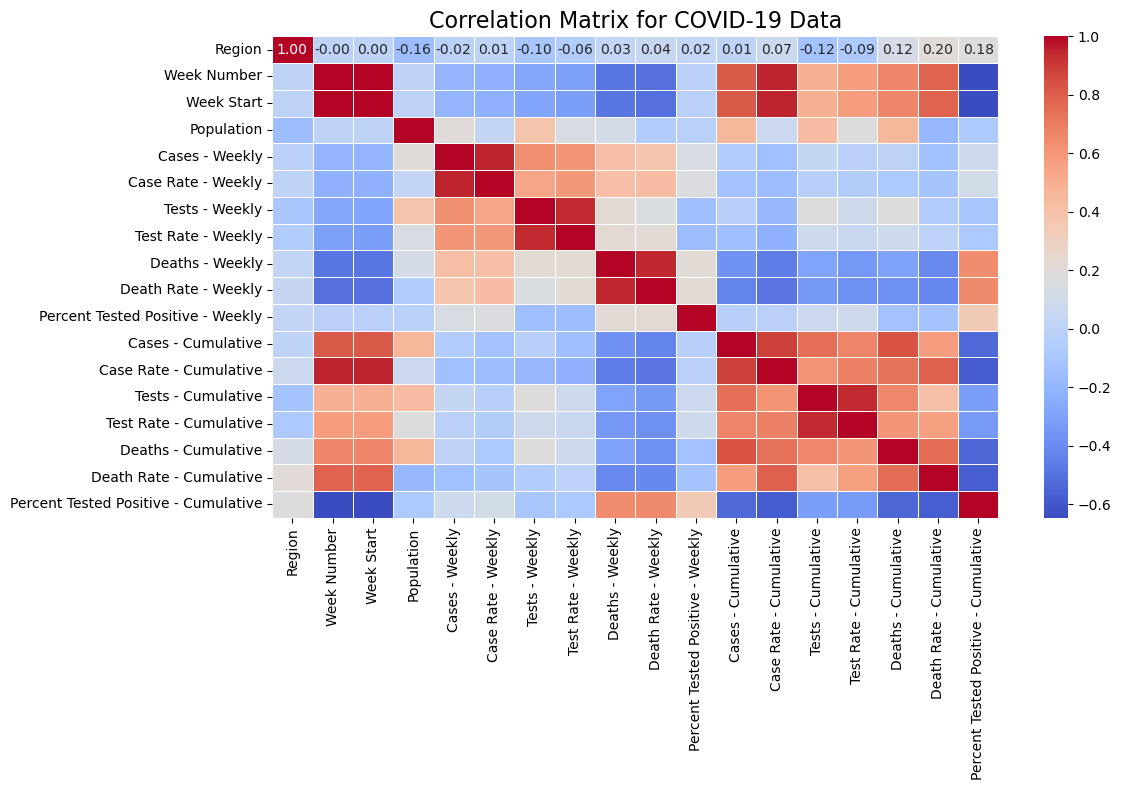

,Region,Week Number,Week Start,Population,Cases - Weekly,Case Rate - Weekly,Tests - Weekly,Test Rate - Weekly,Deaths - Weekly,Death Rate - Weekly,Percent Tested Positive - Weekly,Cases - Cumulative,Case Rate - Cumulative,Tests - Cumulative,Test Rate - Cumulative,Deaths - Cumulative,Death Rate - Cumulative,Percent Tested Positive - Cumulative
0,0,1,2020-03-01,490874,0,0.000,17,3.463,0,0.000,0.000,0,0.000,17,3.463,0,0.000,0.000
1,0,2,2020-03-08,490874,24,4.889,122,24.854,0,0.000,19.672,24,4.889,139,28.317,0,0.000,17.266
2,0,3,2020-03-15,490874,185,37.688,950,193.532,1,0.204,19.474,228,46.448,1089,221.849,1,0.204,20.937
3,0,4,2020-03-22,490874,401,81.691,1517,309.041,1,0.204,26.434,636,129.565,2606,530.890,2,0.407,24.405
4,0,5,2020-03-29,490874,373,75.987,1287,262.185,9,1.833,28.982,1013,206.367,3893,793.075,11,2.241,26.021


In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv('C:/Users/hasal/Desktop/final_project/COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code_-_Historical.csv')

# Clean data first before processing
# ==================================

# Remove ZIP Codes marked as "Unknown"
df = df[df['ZIP Code'] != "Unknown"]

# Extract coordinates first
# ==========================
def extract_coordinates(coord_str):
    try:
        if pd.isna(coord_str):
            return (np.nan, np.nan)
        lon = float(coord_str.split()[1][1:])
        lat = float(coord_str.split()[2][:-1])
        return (lon, lat)
    except:
        return (np.nan, np.nan)

# Apply coordinate extraction
df['Longitude'], df['Latitude'] = zip(*df['ZIP Code Location'].apply(extract_coordinates))

# Remove rows with missing coordinates
df = df.dropna(subset=['Longitude', 'Latitude'])

# Convert dates before filtering
# ===============================
df["Week Start"] = pd.to_datetime(df["Week Start"])
df["Week End"] = pd.to_datetime(df["Week End"])

# Cluster regions
# ================
# Scale coordinates first
coords = df[['Longitude', 'Latitude']].values
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
df['Region'] = kmeans.fit_predict(coords)

# Aggregate data by Region and Week Start
# ========================================
agg_dict = {
    "Cases - Weekly": "sum",
    "Cases - Cumulative": "sum",
    "Tests - Weekly": "sum",
    "Tests - Cumulative": "sum",
    "Deaths - Weekly": "sum",
    "Deaths - Cumulative": "sum",
    "Population": "sum"  # CORRECTED: Changed from mean to sum
}

df_time_series_region = df.groupby(['Region', 'Week Start']).agg(agg_dict).reset_index()
# Calculate positivity rates FIRST
# =================================
# Handle zero-test cases
df_time_series_region['Percent Tested Positive - Weekly'] = np.where(
    df_time_series_region['Tests - Weekly'] > 0,
    (df_time_series_region['Cases - Weekly'] / df_time_series_region['Tests - Weekly']) * 100,
    0
)

df_time_series_region['Percent Tested Positive - Cumulative'] = np.where(
    df_time_series_region['Tests - Cumulative'] > 0,
    (df_time_series_region['Cases - Cumulative'] / df_time_series_region['Tests - Cumulative']) * 100,
    0
)
# Calculate rates per 100,000
# ============================
for time_type in ['Weekly', 'Cumulative']:
    df_time_series_region[f'Case Rate - {time_type}'] = (
        df_time_series_region[f'Cases - {time_type}'] / 
        df_time_series_region['Population']
    ) * 100000
    
    df_time_series_region[f'Test Rate - {time_type}'] = (
        df_time_series_region[f'Tests - {time_type}'] / 
        df_time_series_region['Population']
    ) * 100000
    
    df_time_series_region[f'Death Rate - {time_type}'] = (
        df_time_series_region[f'Deaths - {time_type}'] / 
        df_time_series_region['Population']
    ) * 100000

# Integer columns (no decimals)
integer_columns = [
    "Cases - Weekly", "Cases - Cumulative",
    "Tests - Weekly", "Tests - Cumulative",
    "Deaths - Weekly", "Deaths - Cumulative",
    "Population"
]

# Decimal columns (round to 3 places)
decimal_columns = [
    "Percent Tested Positive - Weekly",
    "Percent Tested Positive - Cumulative",
    "Case Rate - Weekly",
    "Case Rate - Cumulative",
    "Test Rate - Weekly", 
    "Test Rate - Cumulative",
    "Death Rate - Weekly",
    "Death Rate - Cumulative"
]

# Apply rounding
df_time_series_region[integer_columns] = df_time_series_region[integer_columns].astype(int)
df_time_series_region[decimal_columns] = df_time_series_region[decimal_columns].round(3)

# Add region-specific week numbers
# =================================
df_time_series_region = df_time_series_region.sort_values(['Region', 'Week Start'])
df_time_series_region['Week Number'] = df_time_series_region.groupby('Region').cumcount() + 1

# Final column ordering
# ======================
column_order = [
    'Region', 'Week Number', 'Week Start', 'Population',
    'Cases - Weekly', 'Case Rate - Weekly',
    'Tests - Weekly', 'Test Rate - Weekly',
    'Deaths - Weekly', 'Death Rate - Weekly',
    'Percent Tested Positive - Weekly',
    'Cases - Cumulative', 'Case Rate - Cumulative',
    'Tests - Cumulative', 'Test Rate - Cumulative',
    'Deaths - Cumulative', 'Death Rate - Cumulative',
    'Percent Tested Positive - Cumulative'
]

df_time_series_region = df_time_series_region[column_order]

# Final validation check
print("\nFinal validation:")
print("Max Weekly Case Rate:", df_time_series_region['Case Rate - Weekly'].max())
print("Typical Chicago rates should be < 2000 in peak weeks")

# Step 1: Calculate the correlation matrix
correlation_matrix = df_time_series_region.corr()

# Step 2: Extract correlation with target 'Cases - Weekly'
correlation_with_target = correlation_matrix['Cases - Weekly'].sort_values(ascending=False)

# Step 3: Print correlation with 'Cases - Weekly'
print("\nCorrelation with 'Cases - Weekly':")
print(correlation_with_target)

# Step 4: Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix for COVID-19 Data", fontsize=16)
plt.tight_layout()
plt.show()

# Display the final dataset
df_time_series_region.head()

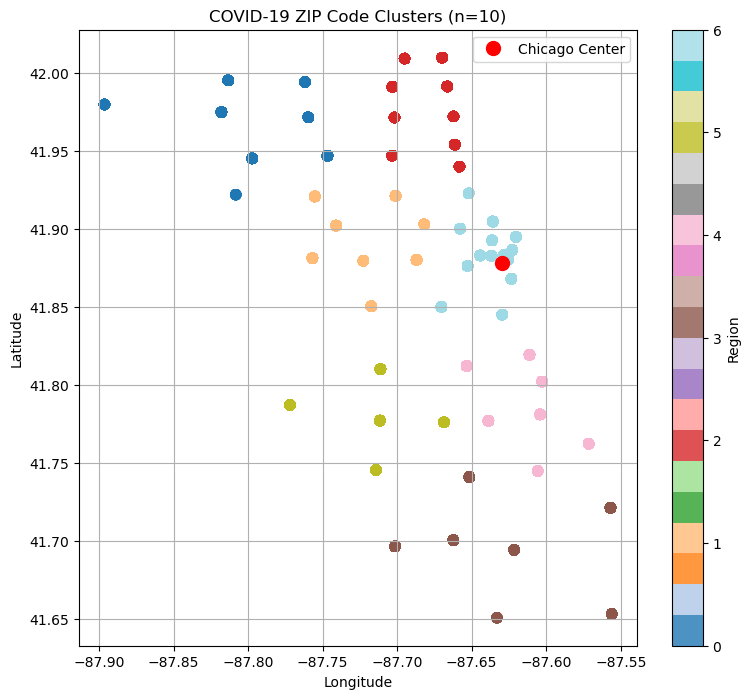

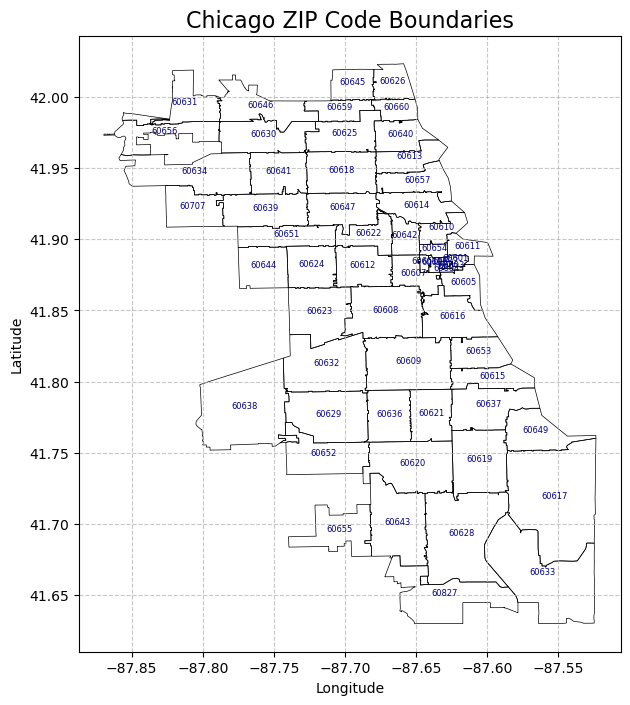

In [9]:
# 1. Generate Cluster Scatter Plot
# ================================
plt.figure(figsize=(9, 8))
scatter = plt.scatter(df['Longitude'], df['Latitude'], c=df['Region'], 
                     cmap='tab20', s=50, alpha=0.8)
plt.colorbar(scatter, label='Region')
plt.title('COVID-19 ZIP Code Clusters (n=10)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add Chicago reference points
plt.plot(-87.6298, 41.8781, 'ro', markersize=10, label='Chicago Center')  # Chicago coordinates
plt.legend()
plt.grid(True)
plt.show()


# Get unique ZIP codes from the dataset
chicago_zips = df["ZIP Code"].unique().astype(str)

# Load Chicago ZIP code boundaries
geojson_url = "https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/il_illinois_zip_codes_geo.min.json"
geojson_data = gpd.read_file(geojson_url)

# Filter to only Chicago ZIP codes from the dataset
geojson_data["ZCTA5CE10"] = geojson_data["ZCTA5CE10"].astype(str)
chicago_map = geojson_data[geojson_data["ZCTA5CE10"].isin(chicago_zips)]

# Create blank map with boundaries
fig, ax = plt.subplots(figsize=(12, 8))
chicago_map.plot(ax=ax,
                facecolor="none",  # No fill
                edgecolor="black",  # Boundary color
                linewidth=0.5,     # Boundary line thickness
                aspect="equal")

# Add context
ax.set_title("Chicago ZIP Code Boundaries", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Optional: Add text labels for ZIP codes
for idx, row in chicago_map.iterrows():
    ax.text(row.geometry.centroid.x,
           row.geometry.centroid.y,
           row.ZCTA5CE10,
           fontsize=6,
           ha='center',
           color='darkblue')

plt.show()

C:\Users\hasal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1644 - mae: 0.3449 - val_loss: 0.0094 - val_mae: 0.1106
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0423 - mae: 0.1769 - val_loss: 0.0055 - val_mae: 0.0789
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0283 - mae: 0.1458 - val_loss: 0.0152 - val_mae: 0.1033
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0254 - mae: 0.1359 - val_loss: 0.0053 - val_mae: 0.0595
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0329 - mae: 0.1430 - val_loss: 0.0062 - val_mae: 0.0647
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0390 - mae: 0.1421 - val_loss: 0.0153 - val_mae: 0.1310
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0277 - mae: 0.1392 - val_loss: 0.0090 - val_mae: 0.0740
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0229 - mae: 0.1127 - val_loss: 0.0127 - val_mae: 0.0828
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0

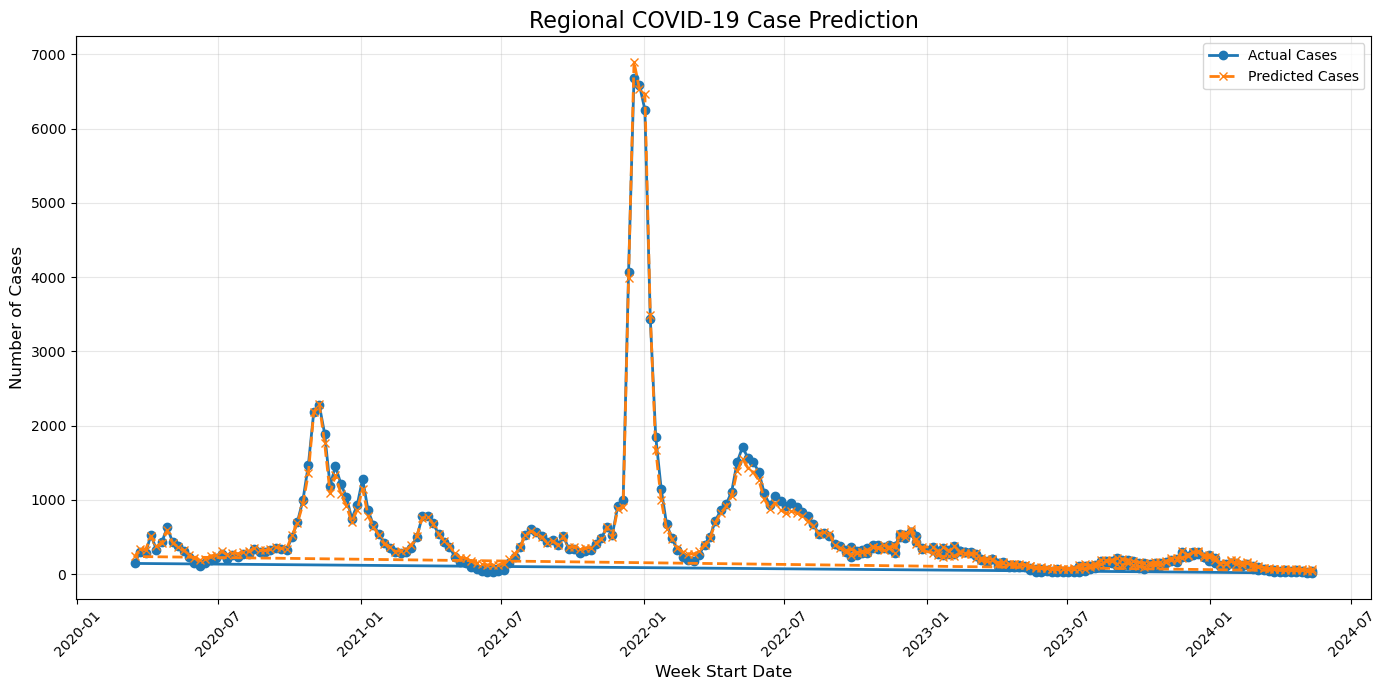

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load preprocessed regional data
df_time_series = df_time_series_region

# Convert dates and sort
df_time_series["Week Start"] = pd.to_datetime(df_time_series["Week Start"])
df_time_series = df_time_series.sort_values(['Region', 'Week Start'])

# Feature Engineering - Lag Features for Test Prediction
# ------------------------------------------------------
# Create region-specific lag features
df_time_series['Tests - Weekly Lag1'] = df_time_series.groupby('Region')['Tests - Weekly'].shift(1)
df_time_series['Test Rate - Weekly Lag1'] = df_time_series.groupby('Region')['Test Rate - Weekly'].shift(1)
df_time_series['Case Rate - Weekly Lag1'] = df_time_series.groupby('Region')['Case Rate - Weekly'].shift(1)



# Drop rows with missing values from lag features
df_time_series = df_time_series.dropna()
# New target
target = 'Cases - Weekly'

# Select features correlated with the new target
features = [
    'Week Number',                    # This can still be useful for trends over time
    'Case Rate - Weekly',             # Strongly correlated with 'Cases - Weekly'
    'Tests - Weekly',                 # Moderately correlated with 'Cases - Weekly'
    'Test Rate - Weekly',             # Moderately correlated with 'Cases - Weekly'
    'Deaths - Weekly',                # Useful feature for predicting cases
    'Death Rate - Weekly'             # Another relevant feature
]

# Prepare data
X = df_time_series[features].values
y = df_time_series[target].values.reshape(-1, 1)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Temporal Train-Test Split (No Shuffling)
test_size = int(len(X_scaled) * 0.2)
X_train, X_test = X_scaled[:-test_size], X_scaled[-test_size:]
y_train, y_test = y_scaled[:-test_size], y_scaled[-test_size:]

# Get corresponding dates for the test set
test_dates = df_time_series['Week Start'].iloc[-test_size:].reset_index(drop=True)

# Enhanced DNN Architecture for Cases Prediction
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Custom Huber Loss Configuration
huber_delta = 1.5  # Adjusted delta for case prediction
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.Huber(delta=huber_delta),
              metrics=['mae'])

# Early Stopping and Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Prediction and Inverse Scaling
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Plot actual vs predicted cases
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_actual, label='Actual Cases', marker='o', linestyle='-', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted Cases', marker='x', linestyle='--', linewidth=2)
plt.title('Regional COVID-19 Case Prediction', fontsize=16)
plt.xlabel('Week Start Date', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [17]:
from sklearn.metrics import r2_score

# Calculate R² score
r2 = r2_score(y_test_actual, y_pred)

print(f"R² Score: {r2:.4f}")
# Model Performance Report
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nModel Performance:")
print(f"- Test Huber Loss: {test_loss:.4f}")
print(f"- MAE: {test_mae:.4f} (Scaled), {scaler_y.inverse_transform([[test_mae]])[0][0]:.1f} (Actual Cases)")


R² Score: 0.9960

Model Performance:
- Test Huber Loss: 0.0017
- MAE: 0.0414 (Scaled), 567.5 (Actual Cases)
